In [1]:
!git clone https://github.com/yujiafeng8888/scCNA.git
%cd scCNA
!pip install .
!pip install infercnvpy

fatal: destination path 'scCNA' already exists and is not an empty directory.
/content/scCNA
Processing /content/scCNA
  Preparing metadata (setup.py) ... done
  Created wheel for scCNA: filename=scCNA-0.1-py3-none-any.whl size=7203 sha256=b558e54ec22479c967531003889ba920872ce44fe5696e88e35d07f79bcc01e3
  Stored in directory: /tmp/pip-ephem-wheel-cache-bcnanttp/wheels/25/cc/c5/ae548f3a909d160258148b54a2721305eb2d68474f5650137d
Successfully built scCNA
  Attempting uninstall: scCNA
    Found existing installation: scCNA 0.1
    Uninstalling scCNA-0.1:
      Successfully uninstalled scCNA-0.1


In [2]:
import scanpy as sc
import scCNA as cna
import matplotlib.pyplot as plt
import infercnvpy as cnv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
adata = sc.read_h5ad("/content/drive/MyDrive/PBMC_simulated_cnas_041025.h5ad")

Mounted at /content/drive


In [3]:
ad_def = cna.find_cnas(
    adata.copy(),
    reference_key='cell_type',
    reference_cat=[
        'CD4 T cell','CD14 monocyte','B cell','CD8 T cell',
        'NK cell','FCGR3A monocyte','Dendritic','Megakaryocyte'
    ],
    threshold=5,
    min_cells=20,
    window_size=100
)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
print(ad_def.shape)

(10309, 19693)


**Calculate the standard metrics**

In [5]:
y_true = (ad_def.obs['simulated_cnvs'].notna()) & (ad_def.obs['simulated_cnvs'] != '')
#y_pred = (ad_def.obs['detect_CNA'].notna()) & (ad_def.obs['detect_CNA'] != '')
y_pred = ad_def.obs['detect_CNA'].apply(lambda x: x != 'none' and isinstance(x, str))

print("=== Cell-level Binary Classification Metrics ===")
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("PR-AUC   :", average_precision_score(y_true, y_pred))

=== Cell-level Binary Classification Metrics ===
Accuracy : 0.36793093413522165
Precision: 0.351875808538163
Recall   : 0.7485614210657994
F1 Score : 0.47872
PR-AUC   : 0.3608882874440729


In [6]:
print(y_pred.value_counts())
print(y_true.value_counts())

detect_CNA
True     8503
False    1806
Name: count, dtype: int64
simulated_cnvs
False    6312
True     3997
Name: count, dtype: int64


**Compare different thresholds**

In [7]:
thresholds = [1, 3, 10]
results = []

for threshold in thresholds:
    adata_tmp = cna.find_cnas(
        adata.copy(),
        reference_key='cell_type',
        reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                       'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
        threshold=threshold,
        min_cells=20,
        window_size=250
    )

    y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
    y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: x != 'none' and isinstance(x, str))


    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((thresholds, acc, prec, rec, f1, pr_auc))


results.sort(key=lambda x: -x[4])

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
print("Threshold sweep results:")
print(f"{'Threshold':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for i, r in enumerate(results):
    print(f"{thresholds[i]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")


Threshold sweep results:
Threshold  Acc      Prec     Recall   F1       PR-AUC  
1          0.388    0.388    1.000    0.559    0.388
3          0.388    0.384    0.959    0.548    0.384
10         0.595    0.302    0.033    0.060    0.385


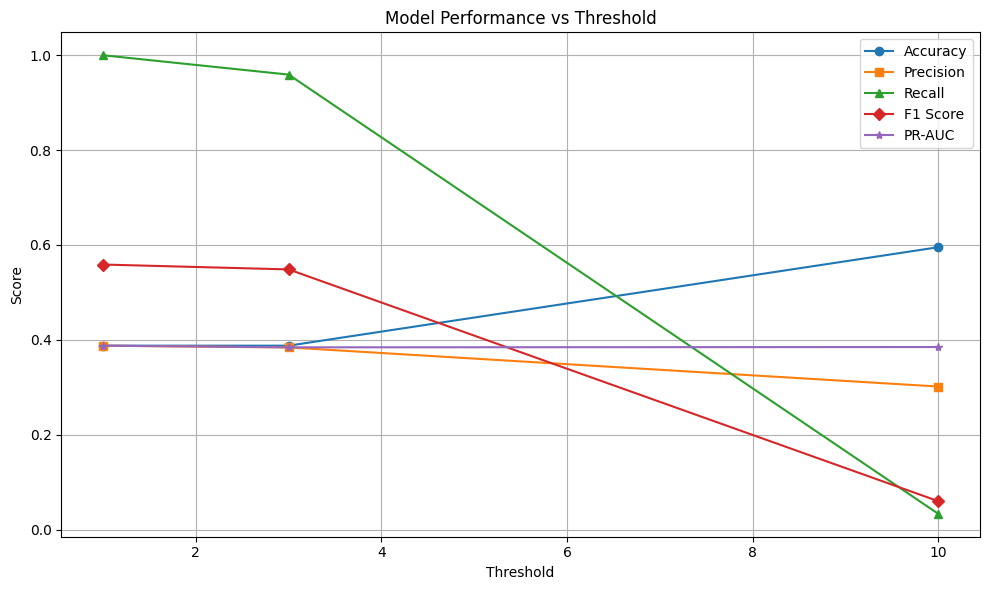

In [9]:
threshold_values = [1, 3, 10]

acc    = [r[1] for r in results]
prec   = [r[2] for r in results]
recall = [r[3] for r in results]
f1     = [r[4] for r in results]
pr_auc = [r[5] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(threshold_values, acc,    marker='o', label='Accuracy')
plt.plot(threshold_values, prec,   marker='s',  label='Precision')
plt.plot(threshold_values, recall, marker='^',  label='Recall')
plt.plot(threshold_values, f1,     marker='D',  label='F1 Score')
plt.plot(threshold_values, pr_auc, marker='*',  label='PR-AUC')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Model Performance vs Threshold")
# plt.xticks(threshold_values)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Compare different min_cells**

In [10]:
min_cells_list = [5, 10, 25]
results = []
y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
for min_cells in min_cells_list:
    adata_tmp = cna.find_cnas(
        adata.copy(),
        reference_key='cell_type',
        reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                       'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
        threshold=5,
        min_cells=min_cells,
        window_size=250
    )
    y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: x != 'none')
    print(y_pred.sum())
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((min_cells, acc, prec, rec, f1, pr_auc))

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


6824


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


6807


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


6756


In [11]:
print("Min_cells sweep results:")
print(f"{'Min_cells':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for i, r in enumerate(results):
    print(f"{min_cells_list[i]:<10} {r[1]:.3f}    {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}")

Min_cells sweep results:
Min_cells  Acc      Prec     Recall   F1       PR-AUC  
5          0.328    0.285    0.487    0.360    0.338
10         0.329    0.285    0.486    0.359    0.338
25         0.332    0.286    0.484    0.360    0.339


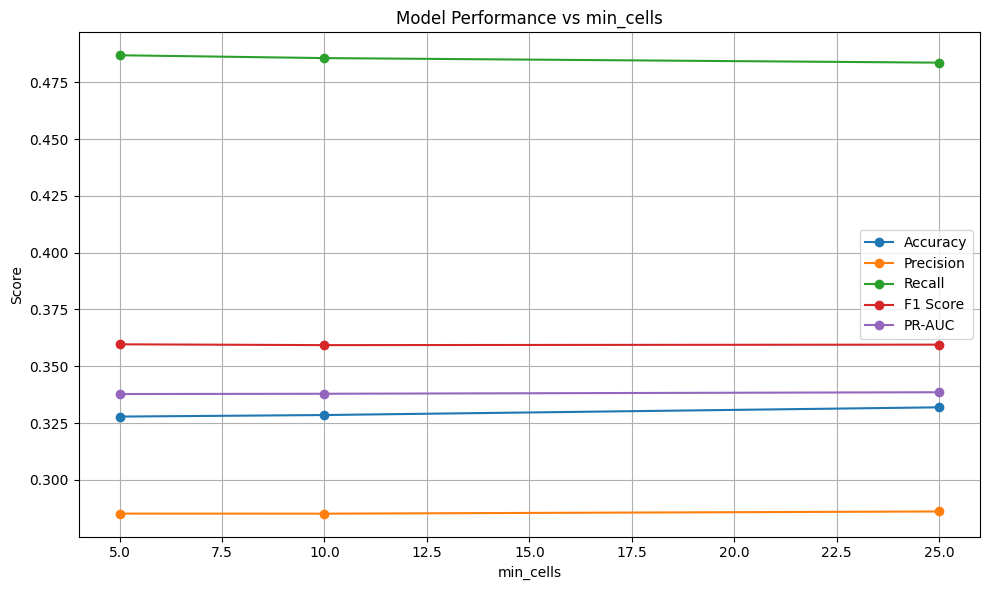

In [12]:
min_cells_values = [5,10,25]
acc = [r[1] for r in results]
prec = [r[2] for r in results]
recall = [r[3] for r in results]
f1 = [r[4] for r in results]
pr_auc = [r[5] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(min_cells_values, acc, marker='o', label='Accuracy')
plt.plot(min_cells_values, prec, marker='o', label='Precision')
plt.plot(min_cells_values, recall, marker='o', label='Recall')
plt.plot(min_cells_values, f1, marker='o', label='F1 Score')
plt.plot(min_cells_values, pr_auc, marker='o', label='PR-AUC')

plt.xlabel("min_cells")
plt.ylabel("Score")
plt.title("Model Performance vs min_cells")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Compare different window_size and min_cells**

In [13]:
window_sizes = [100, 150, 250]
min_cells_list = [5, 10, 25]
results = []

for window_size in window_sizes:
    for min_cells in min_cells_list:
        adata_tmp = cna.find_cnas(
            adata.copy(),
            reference_key='cell_type',
            reference_cat=['CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
                           'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'],
            threshold=5,
            min_cells=min_cells,
            window_size=window_size
        )

        y_true = (adata_tmp.obs['simulated_cnvs'].notna()) & (adata_tmp.obs['simulated_cnvs'] != '')
        y_pred = adata_tmp.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        pr_auc = average_precision_score(y_true, y_pred)

        results.append((window_size, min_cells, acc, prec, rec, f1, pr_auc))


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata

In [14]:
print("Sweep results for window_size × min_cells:")
print(f"{'WinSize':<10} {'MinCells':<10} {'Acc':<8} {'Prec':<8} {'Recall':<8} {'F1':<8} {'PR-AUC':<8}")
for r in results:
    print(f"{r[0]:<10} {r[1]:<10} {r[2]:.3f}    {r[3]:.3f}    {r[4]:.3f}    {r[5]:.3f}    {r[6]:.3f}")


Sweep results for window_size × min_cells:
WinSize    MinCells   Acc      Prec     Recall   F1       PR-AUC  
100        5          0.365    0.352    0.756    0.480    0.361
100        10         0.368    0.353    0.754    0.481    0.361
100        25         0.369    0.352    0.745    0.478    0.361
150        5          0.345    0.321    0.617    0.422    0.346
150        10         0.345    0.319    0.610    0.419    0.346
150        25         0.348    0.320    0.605    0.418    0.347
250        5          0.328    0.285    0.487    0.360    0.338
250        10         0.329    0.285    0.486    0.359    0.338
250        25         0.332    0.286    0.484    0.360    0.339


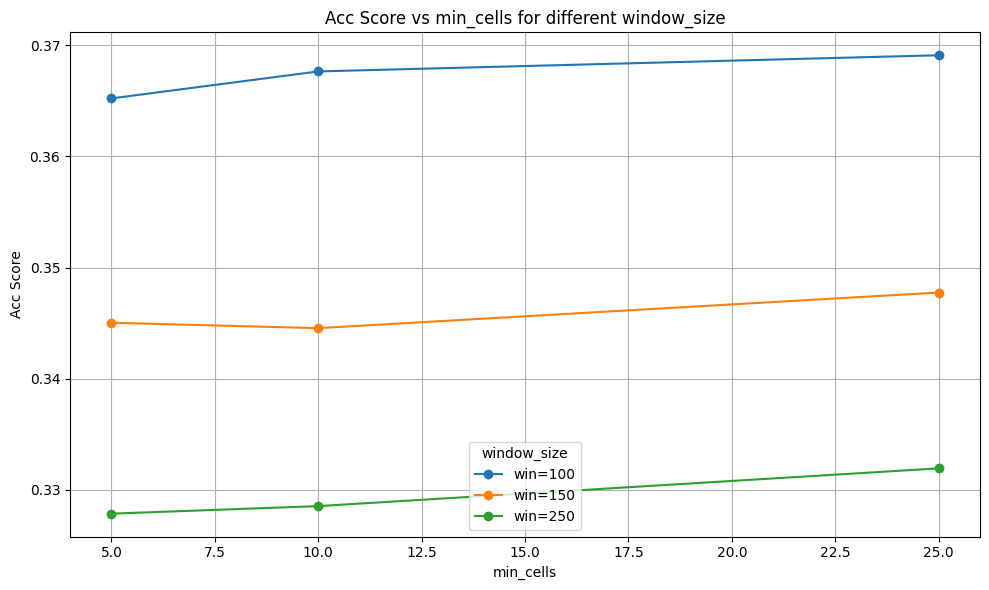

In [15]:
window_sizes = sorted(set(r[0] for r in results))

plt.figure(figsize=(10, 6))

for ws in window_sizes:
    min_cells = [r[1] for r in results if r[0] == ws]
    Acc_scores = [r[2] for r in results if r[0] == ws]

    plt.plot(min_cells, Acc_scores, marker='o', label=f'win={ws}')

plt.xlabel("min_cells")
plt.ylabel("Acc Score")
plt.title("Acc Score vs min_cells for different window_size")
plt.legend(title="window_size")
plt.grid(True)
plt.tight_layout()
plt.show()


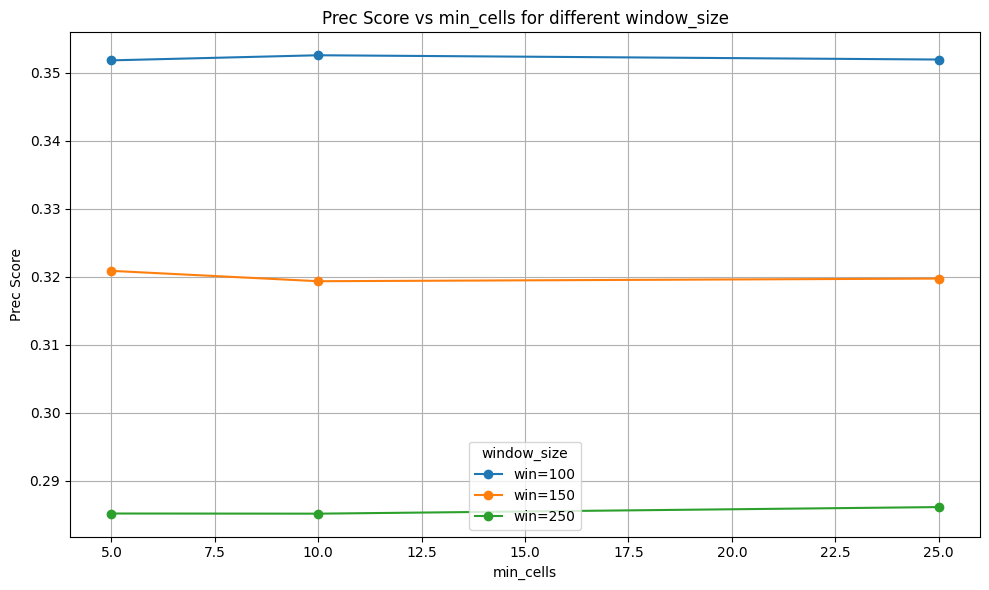

In [16]:
window_sizes = sorted(set(r[0] for r in results))

plt.figure(figsize=(10, 6))

for ws in window_sizes:
    min_cells = [r[1] for r in results if r[0] == ws]
    Prec_scores = [r[3] for r in results if r[0] == ws]

    plt.plot(min_cells, Prec_scores, marker='o', label=f'win={ws}')

plt.xlabel("min_cells")
plt.ylabel("Prec Score")
plt.title("Prec Score vs min_cells for different window_size")
plt.legend(title="window_size")
plt.grid(True)
plt.tight_layout()
plt.show()


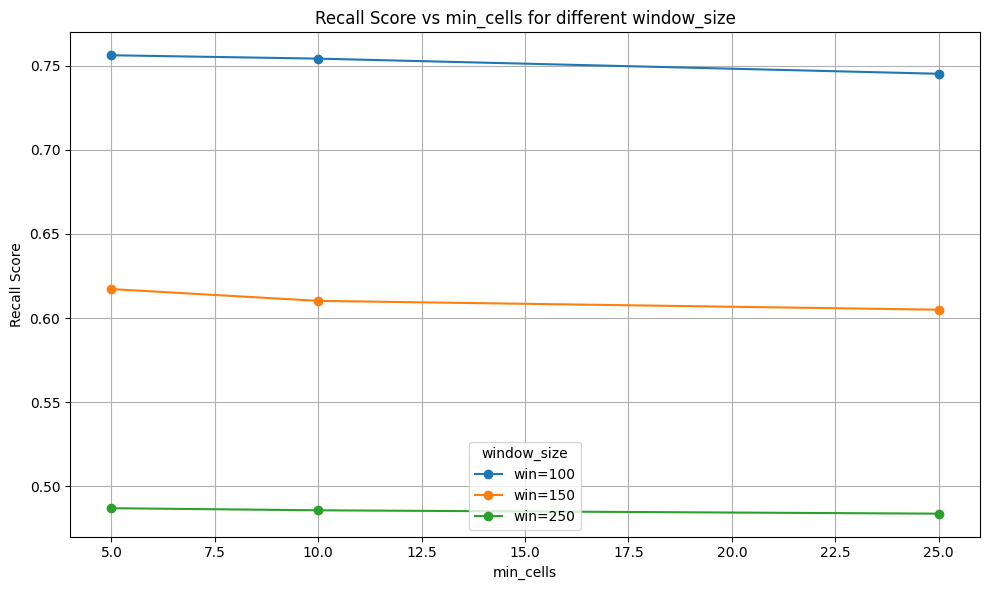

In [17]:
window_sizes = sorted(set(r[0] for r in results))

plt.figure(figsize=(10, 6))

for ws in window_sizes:
    min_cells = [r[1] for r in results if r[0] == ws]
    Recall_scores = [r[4] for r in results if r[0] == ws]

    plt.plot(min_cells, Recall_scores, marker='o', label=f'win={ws}')

plt.xlabel("min_cells")
plt.ylabel("Recall Score")
plt.title("Recall Score vs min_cells for different window_size")
plt.legend(title="window_size")
plt.grid(True)
plt.tight_layout()
plt.show()


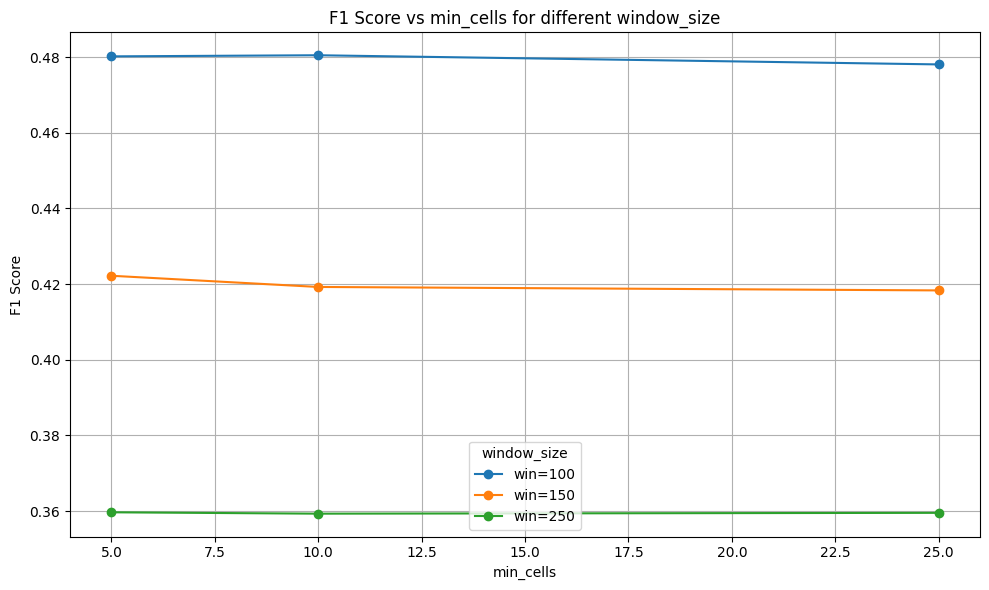

In [18]:
window_sizes = sorted(set(r[0] for r in results))

plt.figure(figsize=(10, 6))

for ws in window_sizes:
    min_cells = [r[1] for r in results if r[0] == ws]
    f1_scores = [r[5] for r in results if r[0] == ws]

    plt.plot(min_cells, f1_scores, marker='o', label=f'win={ws}')

plt.xlabel("min_cells")
plt.ylabel("F1 Score")
plt.title("F1 Score vs min_cells for different window_size")
plt.legend(title="window_size")
plt.grid(True)
plt.tight_layout()
plt.show()


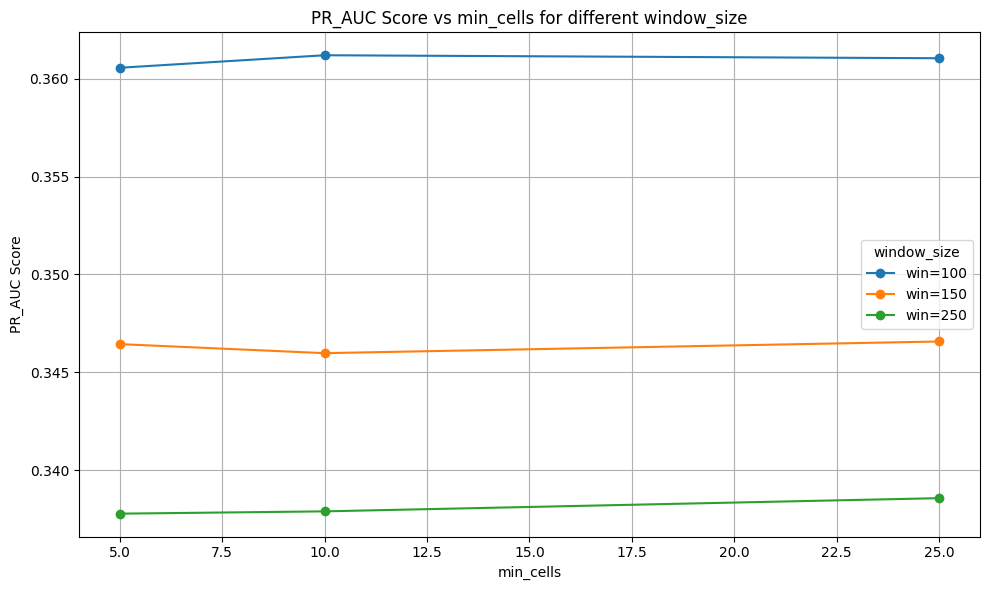

In [19]:
window_sizes = sorted(set(r[0] for r in results))

plt.figure(figsize=(10, 6))

for ws in window_sizes:
    min_cells = [r[1] for r in results if r[0] == ws]
    PR_AUC_scores = [r[6] for r in results if r[0] == ws]

    plt.plot(min_cells, PR_AUC_scores, marker='o', label=f'win={ws}')

plt.xlabel("min_cells")
plt.ylabel("PR_AUC Score")
plt.title("PR_AUC Score vs min_cells for different window_size")
plt.legend(title="window_size")
plt.grid(True)
plt.tight_layout()
plt.show()


**Explore the impact of read depth**

In [ ]:
depths = [500,1000, 2000, 3000,4000,5000]
results = []

for d in depths:
    ad_sub = sc.pp.subsample(adata, n_obs=d, copy=True)
    ad_sub = cna.find_cnas(
        ad_sub,
        reference_key='cell_type',
        reference_cat=[
            'CD4 T cell', 'CD14 monocyte', 'B cell', 'CD8 T cell',
            'NK cell', 'FCGR3A monocyte', 'Dendritic', 'Megakaryocyte'
        ],
        threshold=5,
        min_cells=20,
        window_size=100
    )

    y_true = (ad_sub.obs['simulated_cnvs'].notna()) & (ad_sub.obs['simulated_cnvs'] != '')
    y_pred = ad_sub.obs['detect_CNA'].apply(lambda x: isinstance(x, str) and x != 'none')

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    results.append((d, acc, prec, rec, f1, pr_auc))
    #print(f"Read Depth={d} → Acc={acc:.3f}, Prec={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}, PR-AUC={pr_auc:.3f}")

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata


Summary of performance at different read depths:
Depth    Acc     Prec    Recall  F1      PR-AUC 
--------------------------------------------------
500      0.356   0.322   0.618   0.423   0.345  
1000     0.380   0.354   0.722   0.475   0.364  
2000     0.368   0.348   0.682   0.460   0.363  
3000     0.371   0.345   0.711   0.465   0.357  
4000     0.368   0.346   0.726   0.468   0.356  
5000     0.369   0.349   0.725   0.471   0.360  


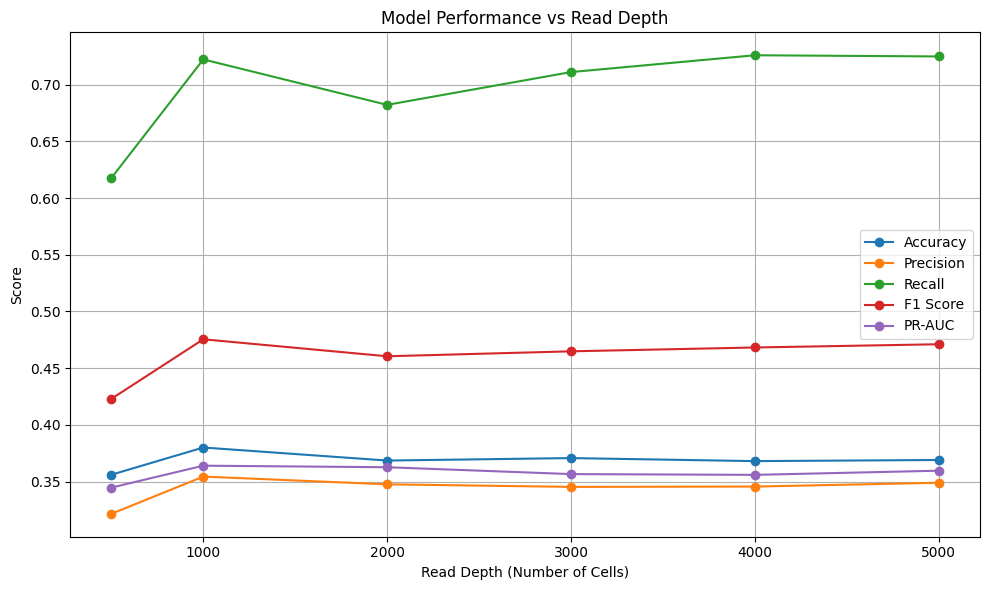

In [ ]:
print("\nSummary of performance at different read depths:")
print(f"{'Depth':<8} {'Acc':<7} {'Prec':<7} {'Recall':<7} {'F1':<7} {'PR-AUC':<7}")
print("-" * 50)
for r in results:
    print(f"{r[0]:<8} {r[1]:<7.3f} {r[2]:<7.3f} {r[3]:<7.3f} {r[4]:<7.3f} {r[5]:<7.3f}")

depths = [r[0] for r in results]
acc = [r[1] for r in results]
prec = [r[2] for r in results]
recall = [r[3] for r in results]
f1 = [r[4] for r in results]
pr_auc = [r[5] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(depths, acc, marker='o', label='Accuracy')
plt.plot(depths, prec, marker='o', label='Precision')
plt.plot(depths, recall, marker='o', label='Recall')
plt.plot(depths, f1, marker='o', label='F1 Score')
plt.plot(depths, pr_auc, marker='o', label='PR-AUC')

plt.xlabel("Read Depth (Number of Cells)")
plt.ylabel("Score")
plt.title("Model Performance vs Read Depth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
